In [217]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm

def tpe(problem, function_evaluations=150, random_warmup=30, gamma=0.2, n=1, **kwargs):

    RANGES = GET_RANGES(problem) 
    
    # Initial warm-up using random search
    for i in range(random_warmup):
        loss,configs=random_search(problem,function_evaluations=100)    

    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss

    sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
    
    good_df, bad_df = good_bad(gamma, sorted_loss_df)
    
    sample(RANGES, good_df, n)
    
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, df):
    
    index_value=int(gamma*(df.shape[0]))
    good_dataframe = df.iloc[:index_value+1]
    bad_dataframe = df.iloc[index_value+1:df.shape[0]]

    good_df=(good_dataframe["configs"].apply(pd.Series))
    bad_df=(bad_dataframe["configs"].apply(pd.Series))

    good_df['loss']=good_dataframe["loss"]
    bad_df["loss"]=bad_dataframe["loss"]
    
    return good_df, bad_df

# Function that constructs l(x) and samples from it
def sample(RANGES, good_df, n):
    
    # List for testing samples
    samples = []
    
    for i in RANGES:  
        x = good_df[i]
        # If categorical, sample uniform
        if RANGES[i]['type'] == 0:
            sample =  np.random.choice(RANGES[i]['range'])
            samples.append(sample)

        else:
            mean, sd = np.mean(x), np.std(x)
            
            if(RANGES[i]['sample'] == 0):
                l_x = normal_dist(x, mean, sd)
            else:
                l_x = normal_dist(np.log(x), mean, sd)
            # Bounds indicate the truncated gaussians
            a,b = -np.inf, np.inf
            # Set prob of values x < a or x > b to '0'
            l_x[x < a], l_x[x > b] = 0, 0

            y_cum = np.cumsum(l_x) / l_x.sum()
            # n indicates candidate samples
            yrand = np.random.rand(n)
            sample = np.interp(yrand, y_cum, x)
            samples.append(sample)
    # Added all the samples to a list to get some results    
    print(samples)

In [218]:
# This gives 1 sample per hyperparameter, since I used n=1 for now
tpe('bad_range')

[4, array([3734.74099926]), array([6586.51168397]), array([1492.01384675]), array([3805.64822919]), 'relu', array([0.])]


<AxesSubplot:ylabel='Density'>

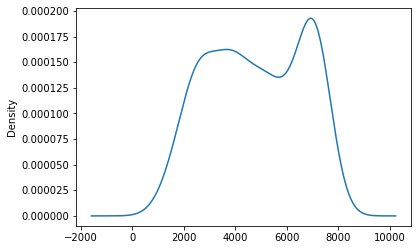

In [216]:
# Below is an example of what the mixture of truncated gaussians looks like for the hyperparameter 'nodes_in_layer_1'
# I warmed up and split the dataframe just like before
# Then I used the 'normal_dist' function to construct l(x), this gives us the points of the PDF
# Apparently dataframes have a built in plot function

gamma = 0.2

for i in range(random_warmup):
    loss,configs=random_search(problem,function_evaluations=100) 
    
hyper_parameters=pd.DataFrame(columns=["configs","loss"])
hyper_parameters["configs"]=configs
hyper_parameters["loss"]=loss

sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
good_df, bad_df = good_bad(gamma, sorted_loss_df)

mean = np.mean(good_df['nodes_in_layer1'])
sd = np.std(good_df['nodes_in_layer1'])

# Construct l(x)
l_x = normal_dist(good_df['nodes_in_layer1'], mean, sd)
# Plot PDF of l(x)
l_x.plot(kind='density')

# The output is as expected: since it is a mixture of truncated gaussians, we do not expect the 'bell curve'.
# We instead expect all Gaussians added together.